# Modello primario

Classificazione binaria del rischio di caduta

✅ Train shape: (53, 43)
✅ Test shape: (18, 43)
✅ Distribuzione target nel test set:
 fallers_1_nonfaller_0
1    0.611111
0    0.388889
Name: proportion, dtype: float64
🔍 Training LogisticRegression

📋 Report - LogisticRegression
              precision    recall  f1-score   support

           0      0.444     0.571     0.500         7
           1      0.667     0.545     0.600        11

    accuracy                          0.556        18
   macro avg      0.556     0.558     0.550        18
weighted avg      0.580     0.556     0.561        18

AUC: 0.662


/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


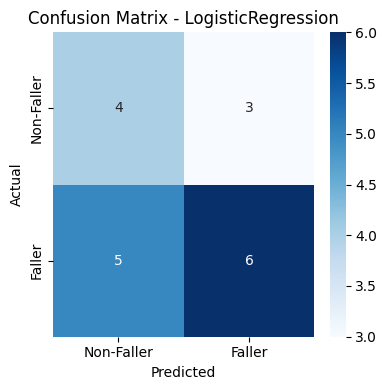

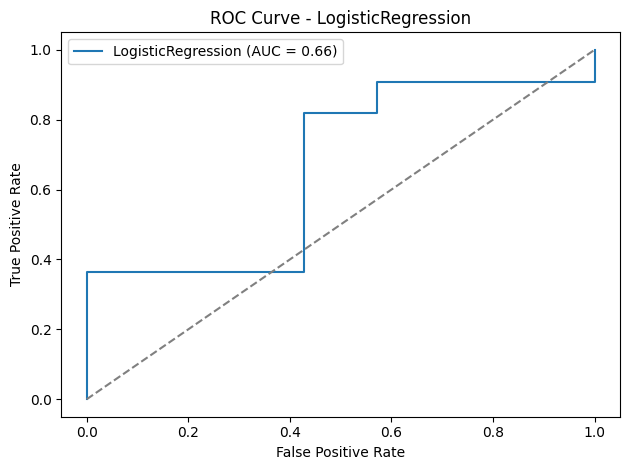

🔍 Training RandomForest

📋 Report - RandomForest
              precision    recall  f1-score   support

           0      0.556     0.714     0.625         7
           1      0.778     0.636     0.700        11

    accuracy                          0.667        18
   macro avg      0.667     0.675     0.662        18
weighted avg      0.691     0.667     0.671        18

AUC: 0.740


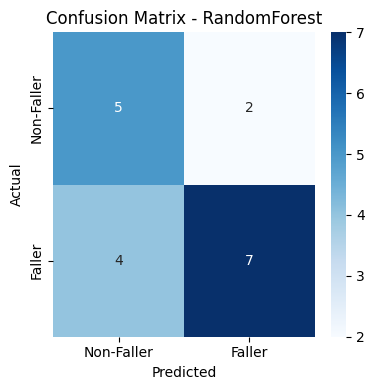

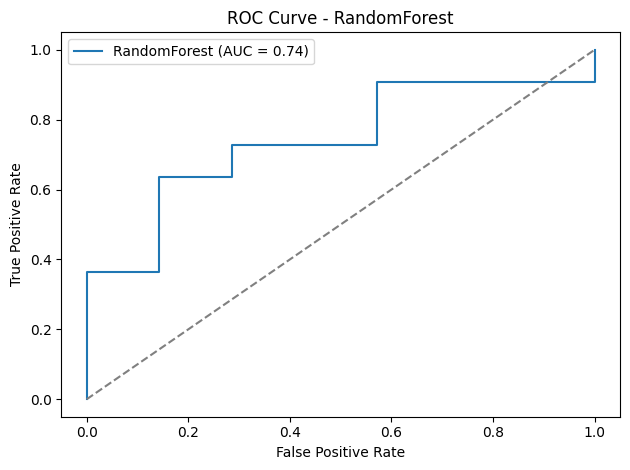

🔍 Training XGBoost

📋 Report - XGBoost
              precision    recall  f1-score   support

           0      0.625     0.714     0.667         7
           1      0.800     0.727     0.762        11

    accuracy                          0.722        18
   macro avg      0.713     0.721     0.714        18
weighted avg      0.732     0.722     0.725        18

AUC: 0.701


/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:11:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


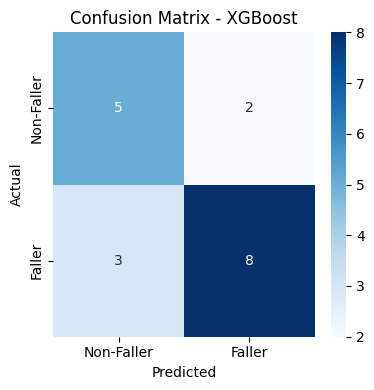

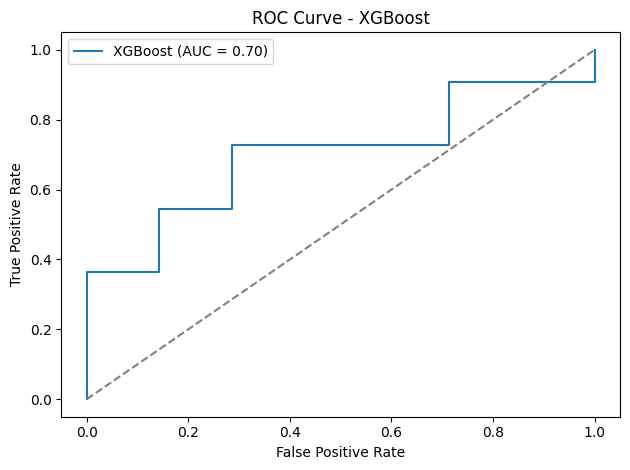

In [2]:
# 03_model_training.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import os
os.makedirs("../results/models", exist_ok=True)
os.makedirs("../results/figures", exist_ok=True)
os.makedirs("../results/tables", exist_ok=True)

# === 1. Caricamento dati ===
df = pd.read_csv("../data/df_fallrisk_clean.csv")

# === 2. Costruzione X e y ===
target = 'fallers_1_nonfaller_0'

# ❗ Escludiamo tutte le variabili target dalle features
target_vars = [
    'total_falls',
    'falls_month_rate',
    'falls_year_rate',
    'fallers_1_nonfaller_0',
    'recurrent_fallers1_nonfallers_occasional0'
]

X = df.drop(columns=target_vars, errors='ignore')
y = df[target]

# === 3. Split stratificato train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

print("✅ Train shape:", X_train.shape)
print("✅ Test shape:", X_test.shape)
print("✅ Distribuzione target nel test set:\n", y_test.value_counts(normalize=True))

# === 4. Modelli ===

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    print(f"🔍 Training {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n📋 Report - {name}")
    print(classification_report(y_test, y_pred, digits=3))
    
    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC: {auc:.3f}")
    
    results[name] = {
        "model": model,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "auc": auc
    }

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Faller", "Faller"], yticklabels=["Non-Faller", "Faller"])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"../results/figures/confusion_matrix_{name}.png", dpi=300)
    plt.show()

    # === ROC Curve ===
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"../results/figures/roc_curve_{name}.png", dpi=300)
    plt.show()

🏁 Decisione
XGBoost è il modello preferibile per questo task, almeno in questa versione iniziale.

Motivazione: ha una migliore trade-off tra recall e precision, mantenendo una buona accuratezza e permettendo generalizzazione più robusta rispetto a RF. Inoltre, XGBoost è più potente per ottimizzazione e explainability avanzata (es. SHAP native support).

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:

✅ Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.8}
✅ Best CV Score (accuracy): 0.6963636363636364
✅ Accuracy on test set: 0.556
              precision    recall  f1-score   support

           0      0.444     0.571     0.500         7
           1      0.667     0.545     0.600        11

    accuracy                          0.556        18
   macro avg      0.556     0.558     0.550        18
weighted avg      0.580     0.556     0.561        18



/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:

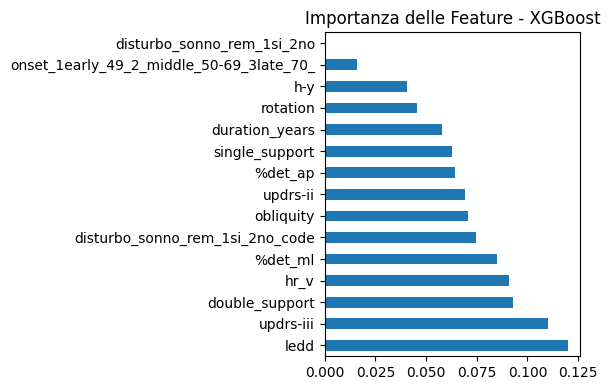

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === 1. Caricamento dati ===
df = pd.read_csv("../data/df_fallrisk_clean.csv")

# === 2. Preparazione X e y (escludendo target di cadute)
target = 'fallers_1_nonfaller_0'
drop_cols = [
    'total_falls',
    'falls_month_rate',
    'falls_year_rate',
    'fallers_1_nonfaller_0',
    'recurrent_fallers1_nonfallers_occasional0',
    'falls_last_year_1si_2no',
    'falls_last_year_1si_2no_code',
    'cadute_con_frattura',
    'mesi_osservati', 'anni_osservati'
]

X = df.drop(columns=drop_cols, errors='ignore')
y = df[target]

# === 3. Feature Selection - Step 1: Filter (univariata)
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)
scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
scores = scores.sort_values(by='Score', ascending=False)

# Salva classifica iniziale
os.makedirs("../results/tables", exist_ok=True)
scores.to_csv("../results/tables/univariate_feature_scores.csv", index=False)

# Seleziona top N feature
top_features = scores['Feature'].head(15).tolist()
X_selected = X[top_features]

# === 4. Split stratificato
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, stratify=y, test_size=0.25, random_state=42
)

# === 5. Tuning XGBoost (GridSearch)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    scoring='accuracy', cv=cv, n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

# === 6. Risultati
print("✅ Best Params:", grid.best_params_)
print("✅ Best CV Score (accuracy):", grid.best_score_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy on test set: {acc:.3f}")
print(classification_report(y_test, y_pred, digits=3))

# === 7. Salva modello
import joblib
os.makedirs("../results/models", exist_ok=True)
joblib.dump(best_model, "../results/models/xgb_best_model.pkl")

# === 8. Salva feature importance
importances = pd.Series(best_model.feature_importances_, index=X_selected.columns).sort_values(ascending=False)
importances.to_csv("../results/tables/xgb_feature_importance.csv")

plt.figure(figsize=(6,4))
importances.plot(kind='barh')
plt.title("Importanza delle Feature - XGBoost")
plt.tight_layout()
plt.savefig("../results/figures/xgb_feature_importance.png", dpi=300)
plt.show()

In [5]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Caricamento dati ===
df = pd.read_csv("../data/df_fallrisk_clean.csv")

# === 2. Costruzione X e y escludendo le variabili collegate alle cadute ===
drop_cols = [
    'total_falls',
    'falls_month_rate',
    'falls_year_rate',
    'fallers_1_nonfaller_0',
    'recurrent_fallers1_nonfallers_occasional0',
    'falls_last_year_1si_2no',
    'falls_last_year_1si_2no_code',
    'cadute_con_frattura',
    'mesi_osservati', 'anni_osservati'
]

X = df.drop(columns=drop_cols, errors='ignore')
y = df['fallers_1_nonfaller_0']

# === 3. Modello base XGBoost ===
model = XGBClassifier(
    n_estimators=50,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# === 4. Cross-validation stratificata 5-fold ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)

# === 5. Output metriche ===
print("✅ Risultati 5-fold cross-validation (media ± std):\n")
for metric in scoring.keys():
    mean = results[f'test_{metric}'].mean()
    std = results[f'test_{metric}'].std()
    print(f"{metric.upper():<10}: {mean:.3f} ± {std:.3f}")

/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:20:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:20:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:20:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dantetrabassi/Desktop/FallRiskPredictor/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:20:

✅ Risultati 5-fold cross-validation (media ± std):

ACCURACY  : 0.592 ± 0.110
PRECISION : 0.660 ± 0.074
RECALL    : 0.706 ± 0.111
F1        : 0.681 ± 0.086
ROC_AUC   : 0.553 ± 0.115
